In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.convolution import Gaussian1DKernel
from astropy.convolution import convolve
from matplotlib import cm

In [3]:
Pk_dict = pickle.load(open('Pk_results.p', 'rb'))
Pk_dict_masked = pickle.load(open('Pk_results_masked.p', 'rb'))

In [4]:
Pk_dict.keys()

dict_keys(['cube_types', 'kbins', 'Pk_arr_continuum', 'Pk_arr_all_lines_Lagache', 'Pk_arr_all_lines_de_Looze', 'Pk_arr_CO_all', 'Pk_arr_CO10', 'Pk_arr_CO21', 'Pk_arr_CO32', 'Pk_arr_CO43', 'Pk_arr_CO54', 'Pk_arr_CO65', 'Pk_arr_CO76', 'Pk_arr_CO87', 'Pk_arr_CI21', 'Pk_arr_CI10', 'Pk_arr_CII_Lagache', 'Pk_arr_CII_de_Looze', 'kmean'])

In [5]:
cube_types = Pk_dict['cube_types']

In [6]:
cube_types

['continuum',
 'all_lines_Lagache',
 'all_lines_de_Looze',
 'CO_all',
 'CO10',
 'CO21',
 'CO32',
 'CO43',
 'CO54',
 'CO65',
 'CO76',
 'CO87',
 'CI21',
 'CI10',
 'CII_Lagache',
 'CII_de_Looze']

In [7]:
#Generate a CI Pk

Pk_dict['Pk_arr_CI'] = Pk_dict['Pk_arr_CI21'] + Pk_dict['Pk_arr_CI10']
Pk_dict_masked['Pk_arr_CI'] = Pk_dict_masked['Pk_arr_CI21'] + Pk_dict_masked['Pk_arr_CI10']

Pk_dict['Pk_arr_CO_CI'] = Pk_dict['Pk_arr_CI'] + Pk_dict['Pk_arr_CO_all']
Pk_dict_masked['Pk_arr_CO_CI'] = Pk_dict_masked['Pk_arr_CI'] + Pk_dict_masked['Pk_arr_CO_all']

In [8]:
freq_index_list = 10. * np.arange(0, 19)
freq_list = freq_index_list + 125.

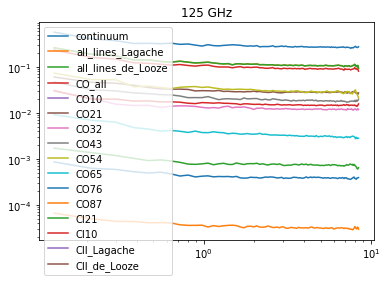

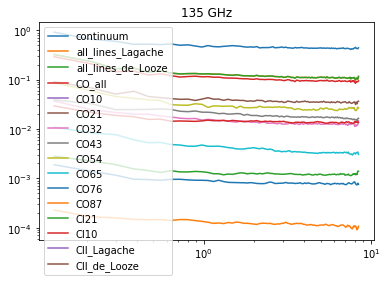

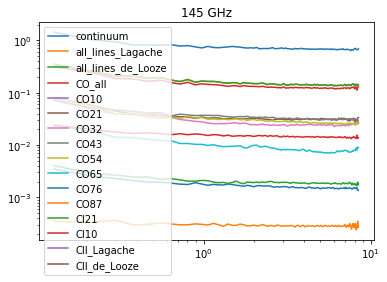

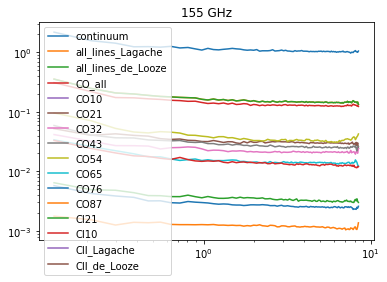

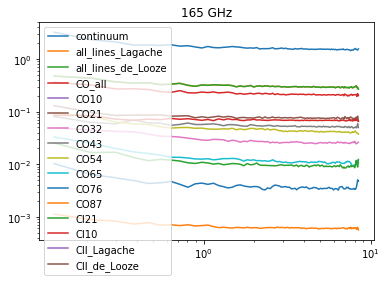

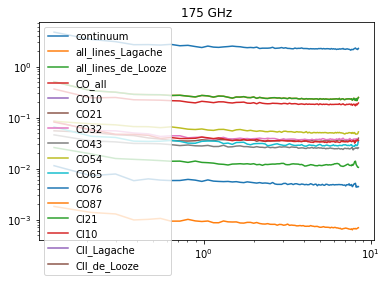

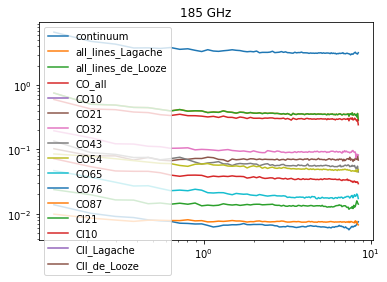

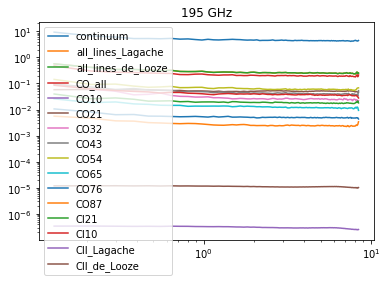

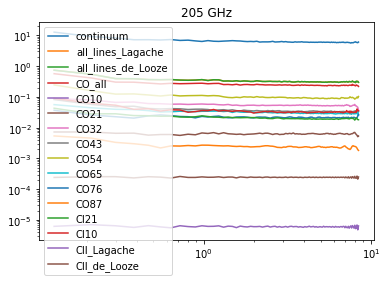

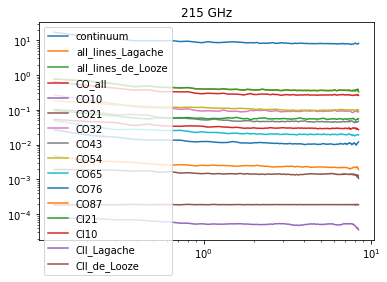

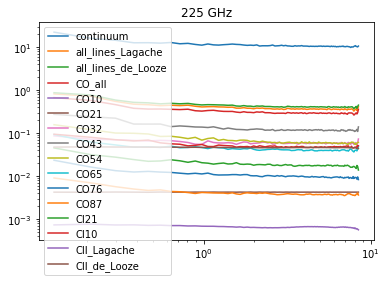

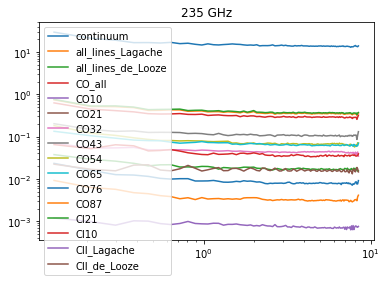

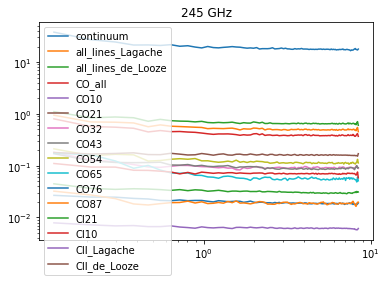

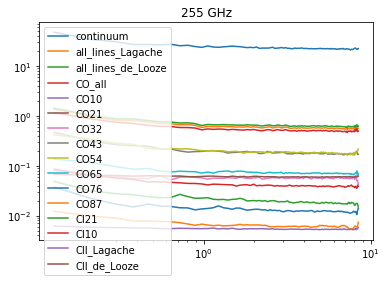

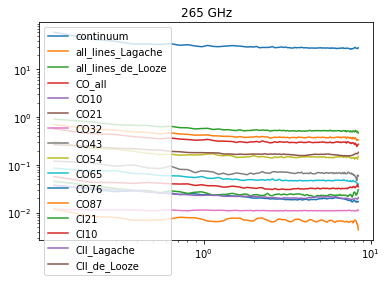

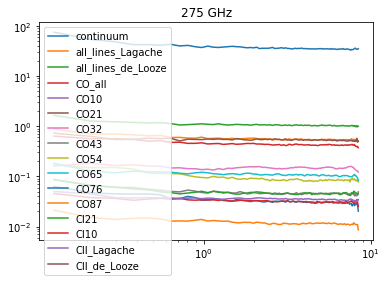

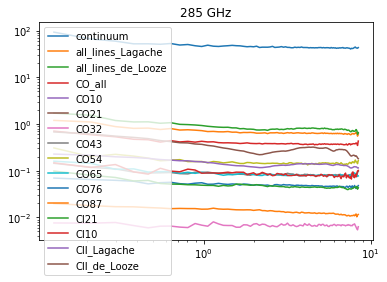

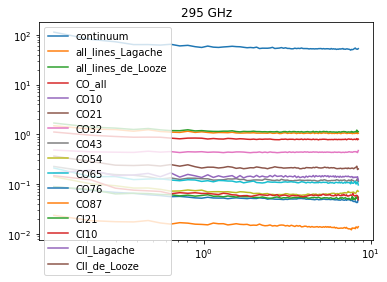

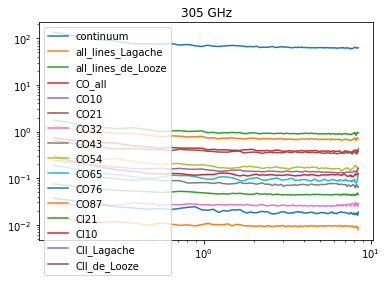

In [9]:
#Normal P(k)

for freq, index in zip(freq_list, freq_index_list):
    for cube_type in cube_types:
        plt.plot(Pk_dict['kmean'][1:], Pk_dict['Pk_arr_'+cube_type][int(index),1:], label = cube_type)
    plt.title('{:0.0f} GHz'.format(freq))
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.show()

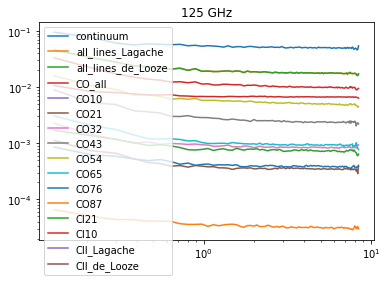

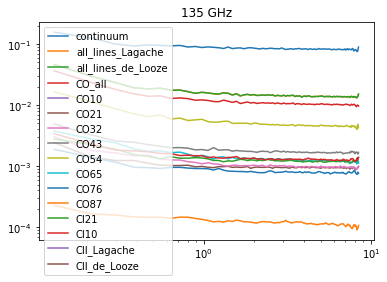

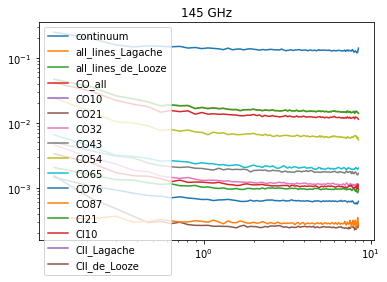

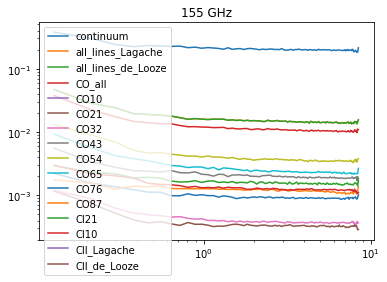

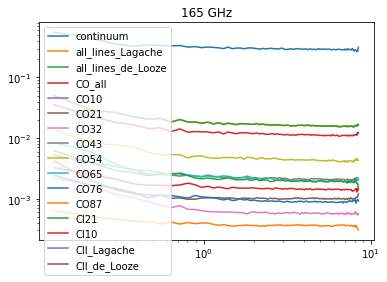

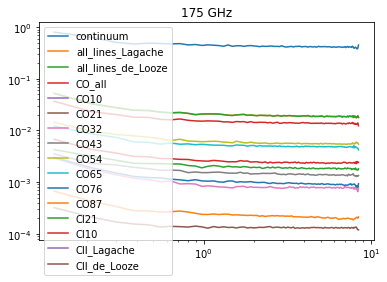

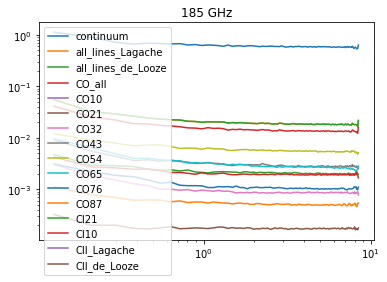

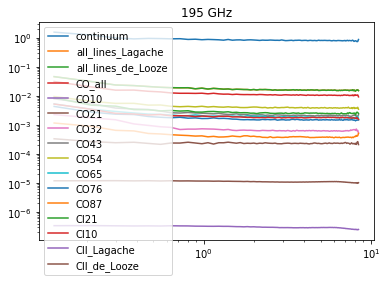

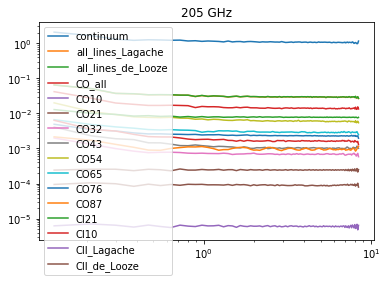

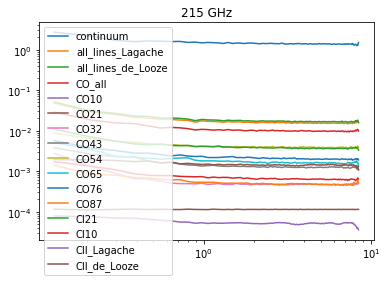

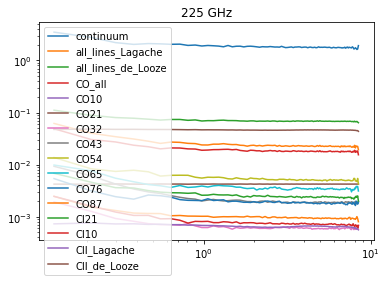

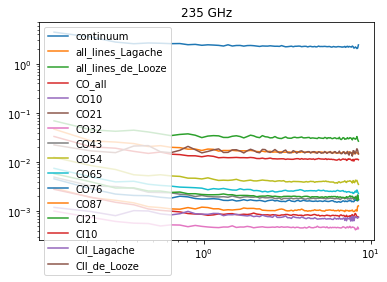

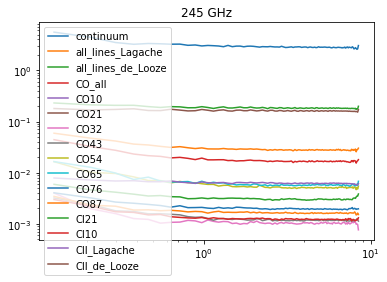

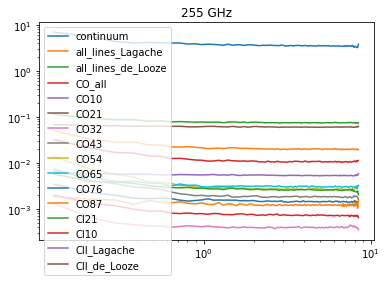

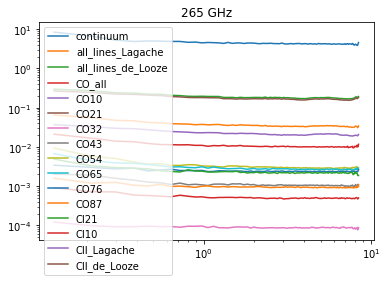

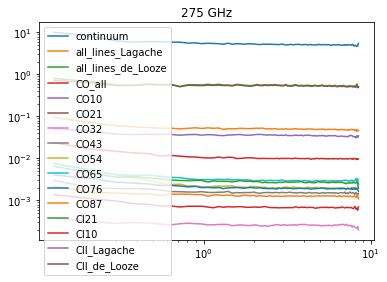

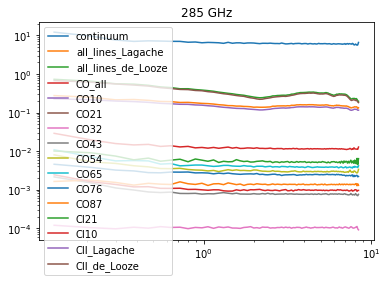

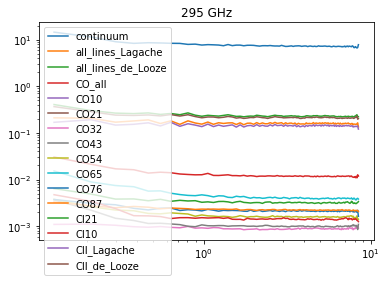

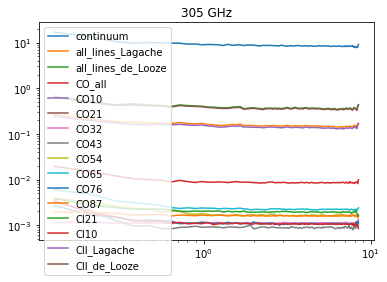

In [10]:
#P(k) with massive galaxies masked

for freq, index in zip(freq_list, freq_index_list):
    for cube_type in cube_types:
        plt.plot(Pk_dict_masked['kmean'][1:], Pk_dict_masked['Pk_arr_'+cube_type][int(index),1:], label = cube_type)
    plt.title('{:0.0f} GHz'.format(freq))
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.show()

In [11]:
#polynome fort the high SFRD model
pcorr = np.poly1d([ 1.32063242e-02, -3.44720436e-01,  3.21803207e+00, -1.31490389e+01, 19.788931271994528])

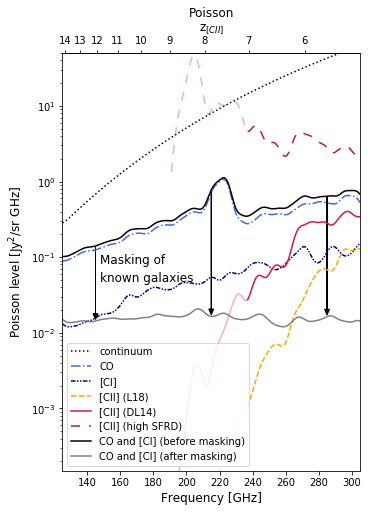

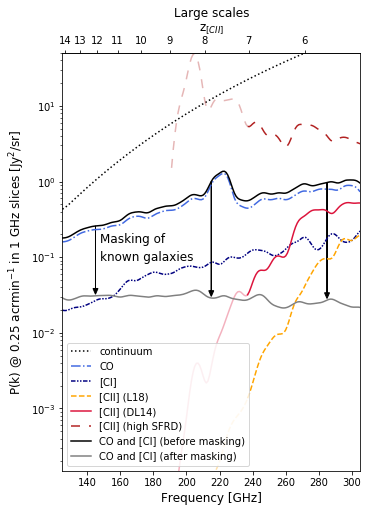

In [12]:
todo = ['continuum', 'CO_all', 'CI', 'CII_Lagache', 'CII_de_Looze', 'CO_CI']
label = ['continuum', 'CO', '[CI]', '[CII] (L18)', '[CII] (DL14)', 'CO and [CI] (before masking)']

colors = ['black', 'royalblue', 'navy', 'orange', 'crimson', 'black']
linestyles = [':', '-.', (0, (3, 1, 1, 1, 1, 1)), '--', '-', '-']

freq_index_arrow = [20,90,160]

freq = np.arange(125,306) * u.GHz

index_poisson = np.where(np.abs(Pk_dict['kmean'].value -6) < 1)
indmin_poisson = np.min(index_poisson)
indmax_poisson = np.max(index_poisson)

index_ls = np.where(np.abs(Pk_dict['kmean'].value - 0.25) < 0.1)
indmin_ls = np.min(index_ls)
indmax_ls = np.max(index_ls)

level_list = []
level_res_list = []

def freq_2_zCII(f):   
    return fCII / f  - 1

def zCII_2_freq(z):
    return fCII / (1+z)

kernel = Gaussian1DKernel(stddev=3)

for k in range(0,2):
    
    fig, ax = plt.subplots(constrained_layout=True, figsize = (5,7))

    for cube_type, lab, color, ls in zip(todo, label, colors, linestyles):
        
        if k ==0:
            level = np.mean(Pk_dict['Pk_arr_'+cube_type][:, indmin_poisson:indmax_poisson], axis = 1)
            #level_masked = np.mean(Pk_dict_masked['Pk_arr_'+cube_type][:, indmin_poisson:indmax_poisson], axis = 1)
        else:
            level = np.mean(Pk_dict['Pk_arr_'+cube_type][:, indmin_ls:indmax_ls], axis = 1)    
            #level_masked = np.mean(Pk_dict_masked['Pk_arr_'+cube_type][:, indmin_ls:indmax_ls], axis = 1) 
    
        level_list.append(convolve(level, kernel, boundary = 'extend'))
        
        if cube_type != 'CII_Lagache' and cube_type != 'CII_de_Looze':
            ax.plot(freq, convolve(level, kernel, boundary = 'extend'), label = lab, color = color, linestyle = ls)
        else:
            safez = np.where(freq.value >= 237)
            ax.plot(freq[safez], convolve(level, kernel, boundary = 'extend')[safez], label = lab, color = color, linestyle = ls)
            safez = np.where(freq.value <=237)
            ax.plot(freq[safez], convolve(level, kernel, boundary = 'extend')[safez], color = color, linestyle = ls, alpha = 0.33)
        
        #Add the high SFRD model
        if cube_type == 'CII_de_Looze':
            corr = 10.**(-1.*pcorr(1900/freq.value-1.))
            #put z>7 with a lower alpha
            sel = np.where((freq.value > 190) & (freq.value <= 237))
            ax.plot(freq[sel[0]], corr[sel[0]]**2 * convolve(level, kernel, boundary = 'extend')[sel[0]], color = 'firebrick', linestyle = (0, (6, 6)), alpha = 0.33)
            #The rest of the data
            sel = np.where(freq.value >= 237)
            ax.plot(freq[sel[0]], corr[sel[0]]**2 * convolve(level, kernel, boundary = 'extend')[sel[0]], label = '[CII] (high SFRD)', color = 'firebrick', linestyle = (0, (6, 6)))
    
    if k ==0:
        level = convolve(np.mean(Pk_dict['Pk_arr_CO_CI'][:, indmin_poisson:indmax_poisson], axis = 1), kernel, boundary = 'extend')
        level_masked = convolve(np.mean(Pk_dict_masked['Pk_arr_CO_CI'][:, indmin_poisson:indmax_poisson], axis = 1), kernel, boundary = 'extend')
    else:
        level = convolve(np.mean(Pk_dict['Pk_arr_CO_CI'][:, indmin_ls:indmax_ls], axis = 1), kernel, boundary = 'extend')
        level_masked = convolve(np.mean(Pk_dict_masked['Pk_arr_CO_CI'][:, indmin_ls:indmax_ls], axis = 1), kernel, boundary = 'extend')
    
    level_res_list.append(level_masked)
    
    ax.plot(freq, level_masked, label = 'CO and [CI] (after masking)', color = 'grey')
        
    for index in freq_index_arrow:
        ax.arrow(freq[index].value, level[index], 0, 1.25*level_masked[index] - level[index], 
                 head_width = 3, head_length=0.2 * level_masked[index], fc = 'k', ec= 'k')
    index = freq_index_arrow[0]+3
    ax.text(freq[index].value, 1.75*np.sqrt(level[index]*level_masked[index]), 'Masking of', size = 12)
    ax.text(freq[index].value, 1.0*np.sqrt(level[index]*level_masked[index]), 'known galaxies', size = 12)
    
    ax.set_yscale('log')
    ax.legend()

    ax.set_xlim([125,305])
    ax.set_ylim([1.5e-4,50])
        
    ax.set_xlabel('Frequency [GHz]', size = 12)
    
    if k ==0:
        ax.set_ylabel(r'Poisson level [Jy$^2$/sr GHz]', size = 12)
        ax.set_title('Poisson', size = 12)
    else:
        ax.set_ylabel(r'P(k) @ 0.25 acrmin$^{-1}$ in 1 GHz slices [Jy$^2$/sr]', size = 12)
        ax.set_title('Large scales', size = 12)

    fCII = 1900.54
    
    secax = ax.secondary_xaxis('top', functions=(freq_2_zCII, zCII_2_freq))
    secax.set_xlabel(r'z$_{[CII]}$', size = 12)
    
    if k ==0:
        str_scale = 'poisson'
    else:
        str_scale = 'ls'
    plt.savefig('Pk_vs_freq_'+str_scale+'.pdf', dpi = 150)
    
    plt.legend(loc=3)

    plt.show()

In [13]:
#Look at the LS one
lev_COCI = level_list[11]
lev_DL14 = level_list[10]
lev_L18 = level_list[9]
lev_res = level_res_list[1]

print(np.interp(305, freq.value, lev_COCI / lev_DL14))
print(np.interp(305, freq.value, lev_COCI / lev_L18))

1.8325612020800748
4.881090142750577


/Users/mbethermin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/Users/mbethermin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


/Users/mbethermin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


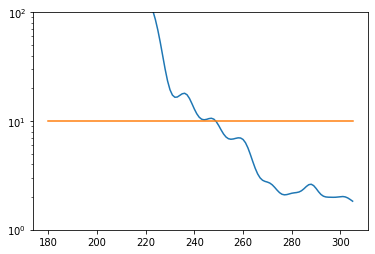

In [14]:
plt.plot(freq.value, lev_COCI / lev_DL14)
plt.plot([180,305],[10,10])
plt.ylim([1.,100.])
plt.yscale('log')

In [15]:
print(np.interp(305, freq.value, lev_DL14 / lev_res))
print(np.interp(305, freq.value, lev_L18 / lev_res))

23.98731671323712
9.005821377007818


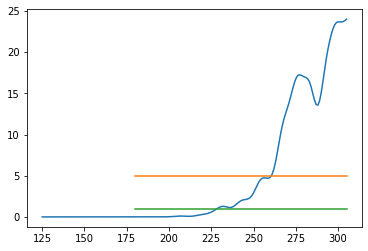

In [16]:
plt.plot(freq.value, lev_DL14 / lev_res)
plt.plot([180,305],[5,5])
plt.plot([180,305],[1,1])


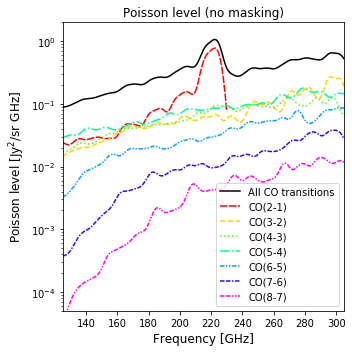

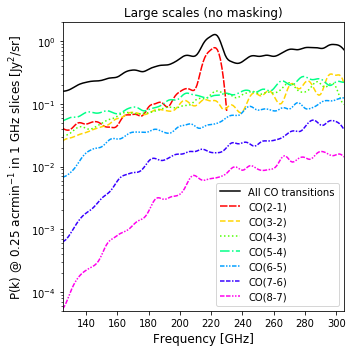

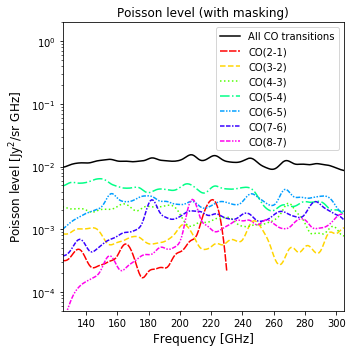

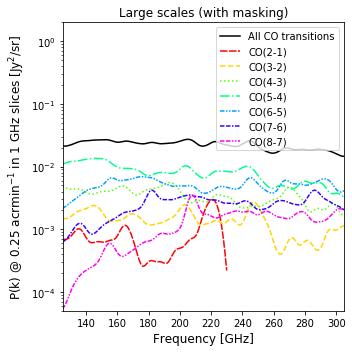

In [17]:
#PLOT CO relative contribution without masking

colormap = cm.hsv

colors = ['black']
colors.extend(list(colormap(np.arange(0,8)/7)))

linestyles = ['-', (0, (5, 1, 5, 1)), '--', ':', '-.',
              (0, (3, 1, 1, 1, 1, 1 )),
              (0, (3, 1, 3, 1, 1, 1)), (0, (3, 1, 3, 1, 1, 1, 1, 1)), '..' ]

for j in range(0,2):
    
    if j == 0:
        Pk_to_use = Pk_dict
        text_masking = ' (no masking)'
        str_masking = 'no_masking'
    else:
        Pk_to_use = Pk_dict_masked 
        text_masking = ' (with masking)'
        str_masking = 'with_masking'

    for i in range(0,2):
    
        plt.figure(figsize=(5,5))
    
        for k in range(0,8):
        
            if k == 0:
                cube_type = 'CO_all'
                cube_name = 'All CO transitions'
            else:
                cube_type = 'CO{:0.0f}{:0.0f}'.format(k+1,k)
                cube_name = 'CO({:0.0f}-{:0.0f})'.format(k+1,k)
        
            if i==0:
                level = np.mean(Pk_to_use['Pk_arr_'+cube_type][:, indmin_poisson:indmax_poisson], axis = 1)
            else:
                level = np.mean(Pk_to_use['Pk_arr_'+cube_type][:, indmin_ls:indmax_ls], axis = 1)
        
            if k == 1:
                sel = np.where(freq < 2 * 115.27 * u.GHz)
            else:
                sel = np.where(freq > 0 * u.GHz)
            
            plt.plot(freq[sel], convolve(level[sel], kernel, boundary = 'extend'),
                     label = cube_name, color = colors[k], linestyle = linestyles[k])
    
    
        plt.yscale('log')
        plt.legend()
        plt.xlim([125,305])
        plt.ylim([5.e-5,2.])
    
        plt.xlabel('Frequency [GHz]', size = 12)
    
        if i ==0:
            plt.ylabel(r'Poisson level [Jy$^2$/sr GHz]', size = 12)
            plt.title('Poisson level'+text_masking, size = 12)
        else:
            plt.ylabel(r'P(k) @ 0.25 acrmin$^{-1}$ in 1 GHz slices [Jy$^2$/sr]', size = 12)
            plt.title('Large scales'+text_masking, size = 12)
            
        if i ==0:
            str_scale = 'poisson'
        else:
            str_scale = 'ls'
        plt.tight_layout()
        plt.savefig('Pk_vs_freq_CO_'+str_scale+'_'+str_masking+'.pdf', dpi = 150)

        plt.show()

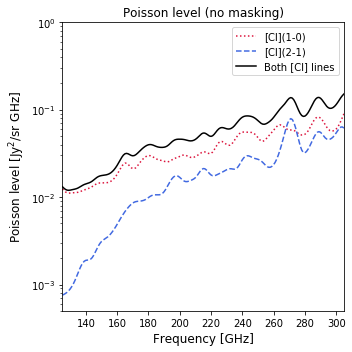

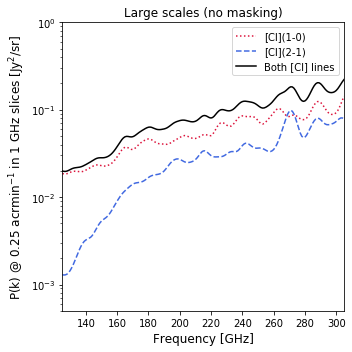

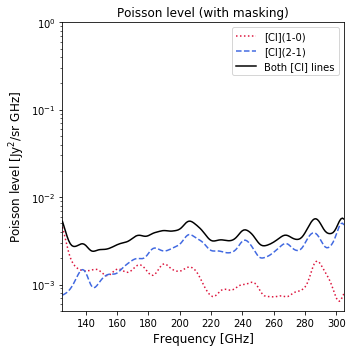

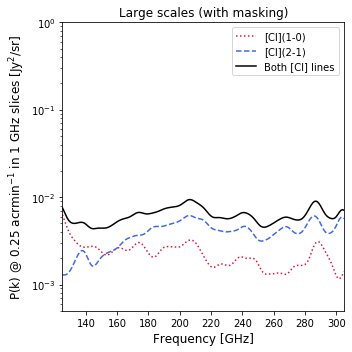

In [18]:
#PLOT CI relative contribution without masking

colors = ['crimson','royalblue', 'black']
linestyles = [':','--', '-']

for j in range(0,2):
    
    if j == 0:
        Pk_to_use = Pk_dict
        text_masking = ' (no masking)'
        str_masking = 'no_masking'
    else:
        Pk_to_use = Pk_dict_masked 
        text_masking = ' (with masking)'
        str_masking = 'with_masking'

    for i in range(0,2):
        
        plt.figure(figsize=(5,5))
    
        for k in range(0,3):
        
            if k < 2:
                cube_type = 'CI{:0.0f}{:0.0f}'.format(k+1,k)
                cube_name = '[CI]({:0.0f}-{:0.0f})'.format(k+1,k)
        
                if i==0:
                    level = np.mean(Pk_to_use['Pk_arr_'+cube_type][:, indmin_poisson:indmax_poisson], axis = 1)
                else:
                    level = np.mean(Pk_to_use['Pk_arr_'+cube_type][:, indmin_ls:indmax_ls], axis = 1)
            
            if k == 0:
                level_tot = level
                label = cube_name
            
            if k == 1:
                level_tot += level
                label = cube_name
            
            if k ==2:
                level = level_tot
                label = 'Both [CI] lines'
            
            
            plt.plot(freq, convolve(level, kernel, boundary = 'extend'),
                     label = label, color = colors[k], linestyle = linestyles[k])

    
        plt.yscale('log')
        plt.legend()
        plt.xlim([125,305])
        plt.ylim([5.e-4,1.])
        plt.xlabel('Frequency [GHz]', size = 12)
    
        if i ==0:
            plt.ylabel(r'Poisson level [Jy$^2$/sr GHz]', size = 12)
            plt.title('Poisson level'+text_masking, size = 12)
        else:
            plt.ylabel(r'P(k) @ 0.25 acrmin$^{-1}$ in 1 GHz slices [Jy$^2$/sr]', size = 12)
            plt.title('Large scales'+text_masking, size = 12)
    
        if i ==0:
            str_scale = 'poisson'
        else:
            str_scale = 'ls'
            
        plt.tight_layout()
        plt.savefig('Pk_vs_freq_CI_'+str_scale+'_'+str_masking+'.pdf', dpi = 150)
        plt.show()

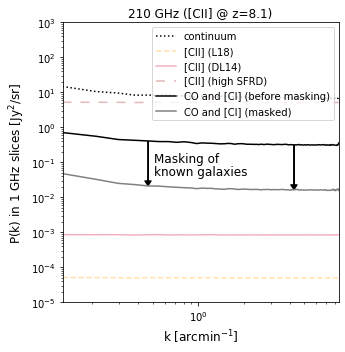

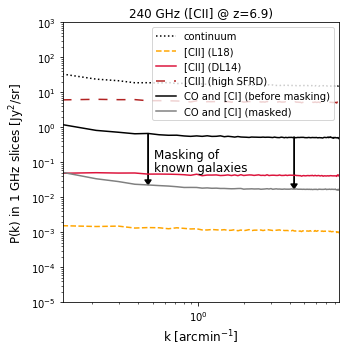

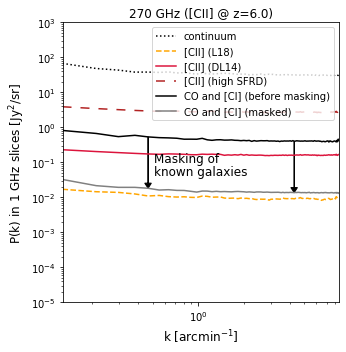

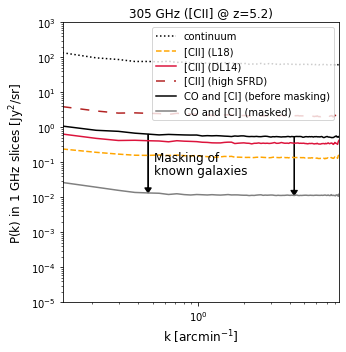

In [19]:
cube_types = ['continuum', 'CII_Lagache', 'CII_de_Looze', 'CO_CI']

label = ['continuum', '[CII] (L18)', '[CII] (DL14)', 'CO and [CI] (before masking)']

colors = ['black', 'orange', 'crimson', 'black']
linestyles = [':', '--', '-', '-']

freq_index_list = [85,115,145,-1]

k_index_list = [5, 50]

for freq_index_plot in freq_index_list:

    plt.figure(figsize = (5,5))

    for k in range(0, len(cube_types)):
        
        if freq_index_plot == 85 and (k==1 or k==2):
            alpha = 0.33
        else:
            alpha = 1
        
        plt.plot(Pk_dict['kmean'][1:], Pk_dict['Pk_arr_'+cube_types[k]][freq_index_plot,1:],
                 label = label[k], linestyle = linestyles[k], color = colors[k], alpha = alpha)
            
        if k == 2:
            corr = 10.**(-1.*pcorr(1900/freq[freq_index_plot].value-1.))
            plt.plot(Pk_dict['kmean'][1:], corr**2 * Pk_dict['Pk_arr_CII_de_Looze'][freq_index_plot,1:], label = '[CII] (high SFRD)', color = 'firebrick', linestyle = (0, (6, 6)), alpha = alpha)
  
    if freq_index_plot == 85:
        alpha = 0.33
    else:
        alpha = 1
        
    plt.plot(Pk_dict_masked['kmean'][1:], Pk_dict_masked['Pk_arr_CO_CI'][freq_index_plot,1:], label = 'CO and [CI] (masked)', color = 'grey')
    
    for index in k_index_list:
        plt.arrow(Pk_dict['kmean'][index].value, Pk_dict['Pk_arr_CO_CI'][freq_index_plot, index].value,
                 0, 1.4 * Pk_dict_masked['Pk_arr_CO_CI'][freq_index_plot, index].value - Pk_dict['Pk_arr_CO_CI'][freq_index_plot, index].value, 
                 head_width = 0.1 * Pk_dict['kmean'][index].value, head_length=0.4 * Pk_dict_masked['Pk_arr_CO_CI'][freq_index_plot, index].value, fc = 'k', ec= 'k')
    plt.text(1.1 * Pk_dict['kmean'][k_index_list[0]].value, 1.4*np.sqrt(Pk_dict_masked['Pk_arr_CO_CI'][freq_index_plot, index].value * Pk_dict['Pk_arr_CO_CI'][freq_index_plot, index].value), 'Masking of', size = 12)
    plt.text(1.1 * Pk_dict['kmean'][k_index_list[0]].value, 0.6*np.sqrt(Pk_dict_masked['Pk_arr_CO_CI'][freq_index_plot, index].value * Pk_dict['Pk_arr_CO_CI'][freq_index_plot, index].value), 'known galaxies', size = 12)
    
    
    zCII = fCII / freq[freq_index_plot].value - 1 
    
    plt.title('{:0.0f} ([CII] @ z={:0.1f})'.format(freq[freq_index_plot], zCII))
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'k [arcmin$^{-1}$]', size = 12)
    plt.ylabel(r'P(k) in 1 GHz slices [Jy$^2$/sr]', size = 12)
    plt.tight_layout()
    plt.legend(loc = 1)
    plt.xlim([np.min(Pk_dict_masked['kmean'][1:].value), np.max(Pk_dict_masked['kmean'][1:].value)])
    plt.ylim([1.e-5,1.e3])
    
    plt.savefig('Pk_vs_k_{:0.0f}GHz.pdf'.format(freq[freq_index_plot].value))
    
    plt.show()